### Initializations

In [2]:
# %matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import os
import sys
import json
import cProfile

from scipy.fft import fft, fftfreq

from slab.instruments.instrumentmanager import InstrumentManager
#from slab.instruments.instrumenttypes import Instrument
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
import experiments as meas
import autocalib_config as cfg

import config

# Figure params
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams.update({'font.size': 13})

expt_path='C:\\_Data\\LLqub2\\Tuning_2024_05_12\\'
print('Data will be stored in', expt_path)

import importlib 
importlib.reload(meas)

# Results config file:
cfg_file = 'autocalibration_cfg.yml'
cfg_path = os.getcwd() + '\\' + cfg_file
#print('Results config will be', cfg_path)
#cfg_path = expt_path + cfg_file
cfg_file = cfg_path 
auto_cfg = config.load(cfg_path)

auto_cfg

# Connect to instruments 
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab

soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)
print(auto_cfg['aliases']['soc'])
print(soc.description())

num_qubits = 6

Could not import QickSoc: No module named 'pynq'
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
imported experiments.clifford_averager_program
imported fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.crud
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy_test
imported experiments.single_qubit.rb_ziqian
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.SingleRB

Note: make sure you set your ADC/DAC channels correctly. This code does not automatically fill in the ADC/DAC into your configuration file, so you should check yourself to make sure these values are correct. 

### Time of Flight (TOF)

TOF measures the time it takes for the signal to run through the wires. It will give us the time in clock ticks that we should wait to make a measurements 

In [ ]:
i = 0
tof = cfg.make_tof(soc, expt_path, cfg_path, i)
tof.go(analyze=False, display=False, progress=True, save=True)
tof.display(adc_trig_offset=150) 

## Resonator Spectroscopy 

Run resonator spectroscopy for all resonators by choosing a large frequency scan to look over. The scan will then find the different resonators and fill in the config file with their respective frequencies. In the autocalibration, there will be a finer sweep of each resonator to more accurately find its frequency. The frequencies are saved in <code>auto_cfg.device.readout.frequency</code>

### Coarse 

In [ ]:
rspec = cfg.make_rspec_coarse(soc, expt_path, cfg_path, i, im=im, start=7000, span=500, reps=2000, npts=5000)
rspec.go(analyze=False, display=False, progress=True, save=True)
rspec.analyze(fit=False, coarse_scan = True)
rspec.display(fit=False, coarse_scan = True)
res_values = rspec.data['coarse_peaks']

In [ ]:
# Optional, play around with the finding peaks: 
rspec.analyze(fit=False, coarse_scan = True)
rspec.display(fit=False, coarse_scan = True)
res_values = rspec.data['coarse_peaks']

### Fine

In [ ]:
# Fine 
for i in range(len(res_values)):
#for i in range(0):
    if i<num_qubits: qubit_i=i
    else: qubit_i=0
    # Next, run the fine scan for each to make sure they are good. 
    rspec = cfg.make_rspec_fine(soc, expt_path, cfg_path, qubit_i, i, im=im, center=res_values[i])
    rspec.go(analyze=True, display=True, progress=True, save=True)
    if i<num_qubits:
        auto_cfg = config.update_readout(cfg_file, 'frequency', float(rspec.data['lorentz_fit'][2]), i)
        auto_cfg = config.update_readout(cfg_file, 'kappa', float(2*rspec.data['lorentz_fit'][3]), i)

In [ ]:
rspec.analyze(fit=True, findpeaks=False, coarse_scan = False)
rspec.display(fit=True, findpeaks=False, coarse_scan = False)

In [ ]:
# Just run one qubit 
i = 0
#config.update_readout(cfg_file, 'gain', 4000, i)

rspec = cfg.make_rspec_fine(soc, expt_path, cfg_path, i, i, im=im, reps=2000)
rspec.go(analyze=True, display=True, progress=True, save=True)
auto_cfg = config.update_readout(cfg_file, 'frequency', float(rspec.data['lorentz_fit'][2]), i)
auto_cfg = config.update_readout(cfg_file, 'kappa', float(2*rspec.data['lorentz_fit'][3]), i)

In [ ]:
i = 0
#config.update_readout(cfg_file, 'gain', 4000, i)

rspec = cfg.make_rspec_fine(soc, expt_path, cfg_path, i, i, im=im, reps=2000)
rspec.go(analyze=False, display=False, progress=True, save=True)
rspec.analyze(hanger=True)
rspec.display(hanger=True)

In [ ]:
rspec.data.keys()

If you are okay with the peaks, save data to <code>auto_cfg.device.readout.frequency</code>

### Resonator Power Spectroscopy 

Find a good value for gain to park your readout at until you run readout optimization. From the 2D sweep that is produced, choose a value for gain that is right before the resonator 'breaks' (goes from e -> f). Want to choose a high value for gain because we want to be in the shot noise limited regime which increases our signal:noise ratio. The gain value should be saved in <code>auto_cfg.device.readout.gain</code>

In [ ]:
i = 1
rpowspec=cfg.make_rpowspec(soc, expt_path, cfg_path, i, im=im, auto_cfg['device']['readout']['frequency'][i], npts_f=1000, npts_gain=20, start_gain=1000, span_gain=21000, smart=True, reps=2000)
rpowspec.go(analyze=False, display=False, progress=True, save=True)

# Testing 
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False)

In [ ]:
# assign the resonator gain to the results config file
gain_values = [12000, 4000, 8000, 6000, 8750, 8000]
for i in range(num_qubits):
    auto_cfg = config.update_readout(cfg_file, 'gain', int(gain_values[i]), i)

## Qubit Spectroscopy

### Coarse

High power and wide

In [ ]:
# You may want to update this frequency, which will be the center of the scan. 
#auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(3300), i)
i=5
print('Running qubit spectroscopy for qubit', i)
qspec = cfg.make_qspec(soc, expt_path, cfg_path, i, im=im, coarse=True)
qspec.go(analyze=False, display=False, progress=True, save=True)

qspec.analyze(fit=False, coarse=True)
qspec.display(fit=False, coarse=True)

In [ ]:
qspec.analyze(fit=False, coarse=True)
qspec.display(fit=False, coarse=True)

#### Updating frequencies 

In [ ]:
# Here, choose which peak you want to save the value for, adjust index accordingly

auto_cfg = config.update_qubit(cfg_file, 'f_ef', float(qspec.data["coarse_peaks_x"][0]), i)
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(qspec.data["coarse_peaks_x"][1]), i)

In [ ]:
3083.359906874908
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(3084.32), i)

### Medium 
(choose your own gain, span)

In [ ]:
qspec = cfg.make_qspec(soc, expt_path, cfg_path, i, im=im, coarse=True,span=25, gain=15000, reps=50)
qspec.go(analyze=False, display=False, progress=True, save=True)

qspec.analyze(fit=False, coarse=True)
qspec.display(fit=False, coarse=True)

### Fine

In [ ]:
# Fine 
qspec = cfg.make_qspec(soc, expt_path, cfg_path, i, im=im, gain=500)
qspec.go(analyze=False, display=False, progress=True, save=True)

qspec.analyze(fit=True, signs = [1,-1,-1])
qspec.display(fit=True, signs= [1, -1, -1])


In [ ]:
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(qspec.data["fit_amps"][2]), i)
auto_cfg = config.update_qubit(cfg_file, 'kappa', float(2*qspec.data["fit_amps"][3]), i)

### Chi

In [ ]:
i=5
chi = cfg.make_chi(soc, expt_path, cfg_path, i, go=True)
chi_val = auto_cfg.device.readout.frequency[i] - chi.data['lorentz_fit'][2]
auto_cfg = config.update_readout(cfg_file, 'chi', float(chi_val), i)


### EF Spectroscopy

#### Coarse

  0%|          | 0/3 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00000_qubit_EF_spectroscopy_qubit2.h5
Found peak in amps at [MHz] 3372.3287363740924, HWHM -1.588329002398688
Found peak in I at [MHz] 3362.5062764446075, HWHM -18.44815832040687
Found peak in Q at [MHz] 3372.069137996153, HWHM -1.4020468682494853


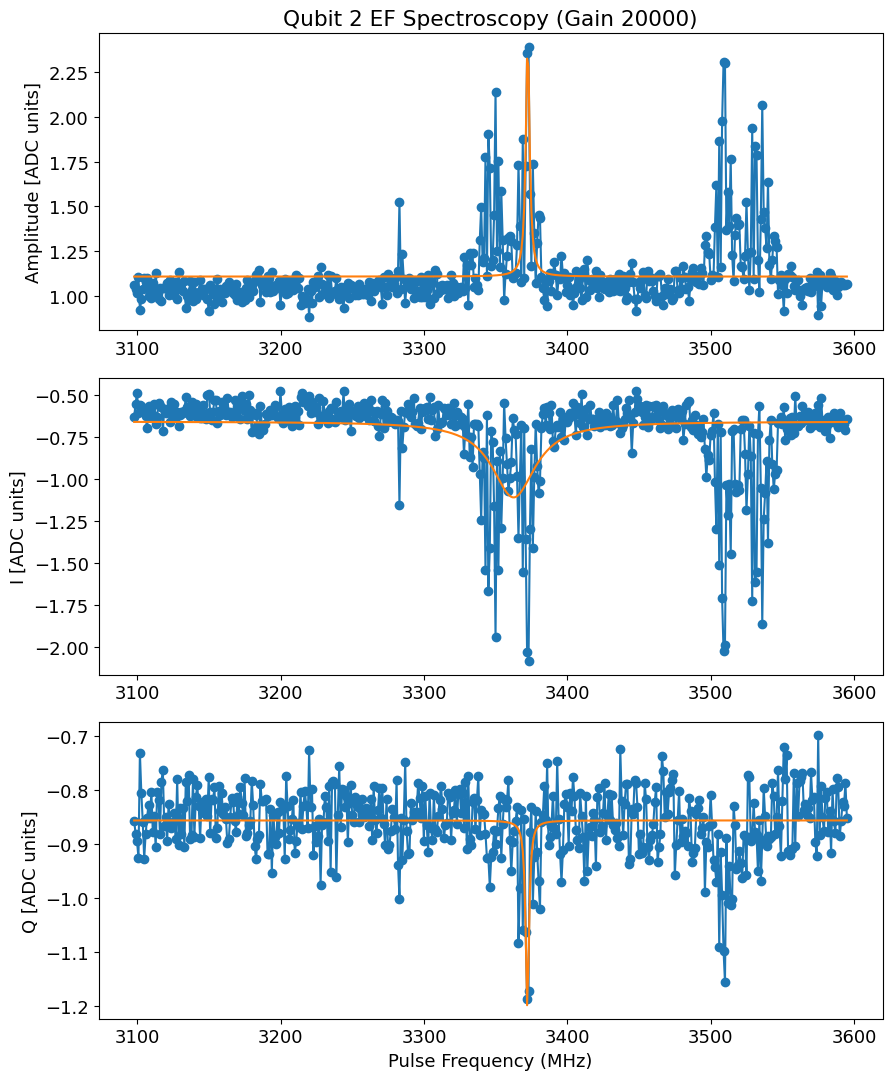

In [92]:
i=2
qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i, im=im, go=False, coarse=True)
qspec.go(analyze=False, display=False, progress=True, save=True)
qspec.analyze()
qspec.display()

#### Fine

In [ ]:
# EF spectroscopy fine 
qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i,go=True, im=im)

In [91]:
auto_cfg = config.update_qubit(cfg_file, 'f_ef', float(qspec.data["fit_amps"][2]), i)

*Set cfg qubit 1 f_ef to 3391.493521164582 from 3390.636601049862*


### Medium

In [ ]:
#qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i, im=im, go=False, coarse=True, span=100, gain=5000, npts=200)
qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i, im=im, go=True, coarse=True, gain=1000, npts=200, span=50)
#qspec = cfg.make_qspec_ef(soc, expt_path, cfg_path, i, im=im, go=False, coarse=False, gain=300)

In [ ]:
qspec.go(analyze=False, display=False, progress=True, save=True)
qspec.analyze(fit=True, coarse=False)
qspec.display(fit=True, coarse=False)


In [ ]:

#auto_cfg = config.update_qubit(cfg_file, 'f_ef', float(qspec.data["fit_amps"][2]), i)
auto_cfg = config.update_qubit(cfg_file, 'f_ef', float(2882.25), i)

## Coherent scans

### Rabi

In [ ]:
# We don't need this for initial tuning 
lengthrabi = cfg.make_lengthrabi(soc, expt_path, cfg_path, i, gain=15000)
lengthrabi.go(analyze=True, display=True, progress=True, save=True)

auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ge','sigma'), float(lengthrabi.data['pi_length']), i)

In [ ]:
amp_rabi = cfg.make_amprabi(soc, expt_path, cfg_path, i, go=True, gain=15000, im=im)
auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ge','gain'), int(amp_rabi.data['pi_length']), i)


In [ ]:
amp_chevron = cfg.make_amprabi_chevron(soc, expt_path, cfg_path, i, sigma=0.4, span_f=8)
amp_chevron.go(analyze=True, display=True, progress=True, save=True)

### Ramsey

In [ ]:
t2r=cfg.make_t2r(soc, expt_path, cfg_path, i, go=True, im=im)
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(t2r.data['new_freq']), i)

In [ ]:
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(t2r.data['new_freq']), i)

#auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(3553.6547824956374), i)



### T1

In [ ]:
t1 = cfg.make_t1(soc, expt_path, cfg_path, i, go=True, im=im) 
auto_cfg = config.update_qubit(cfg_file, 'T1', float(t1.data['new_t1']), i)

### Single Shot

In [ ]:
# Single shot 
#config.update_readout(cfg_file, 'gain', 8000, i)
config.update_readout(cfg_file, 'readout_length',12,i)
shot = cfg.make_singleshot(soc, expt_path, cfg_path, i, go=True)
config.update_readout(cfg_file, 'phase', float(shot.data['angle']), i);
config.update_readout(cfg_file, 'threshold', float(shot.data['thresholds'][0]), i);

<Pyro4.core.Proxy at 0x1d924a70280; not connected; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00003_single_shot_qubit0.h5
Unrotated:
Ig -0.5676701925684838 +/- 4.671756714643694 	 Qg 2.5583129915920804 +/- 4.70775579663333 	 Amp g 2.620537122515069
Ie 9.886221860591267 +/- 5.335513162806027 	 Qe 11.185381068619474 +/- 5.217220484203576 	 Amp e 14.928165738866365
If 7.545294277190127 +/- 4.959908139770873 	 Qf 14.897206400867914 +/- 5.3109670465284 	 Amp f 16.69904860402107
hi
Rotated:
Ig 1.770863610465022 +/- 4.671756714643694 	 Qg 1.9375965276057718 +/- 4.70775579663333 	 Amp g 2.624926328615559
Ie 14.900754102734638 +/- 5.335513162806027 	 Qe -2.0310929715515833 +/- 5.217220484203576 	 Amp e 15.038544194477383
If 16.573433378613288 +/- 4.959908139770873 	 Qf 1.8832303054101684 +/- 5.3109670465284 	 Amp f 16.680085441584175


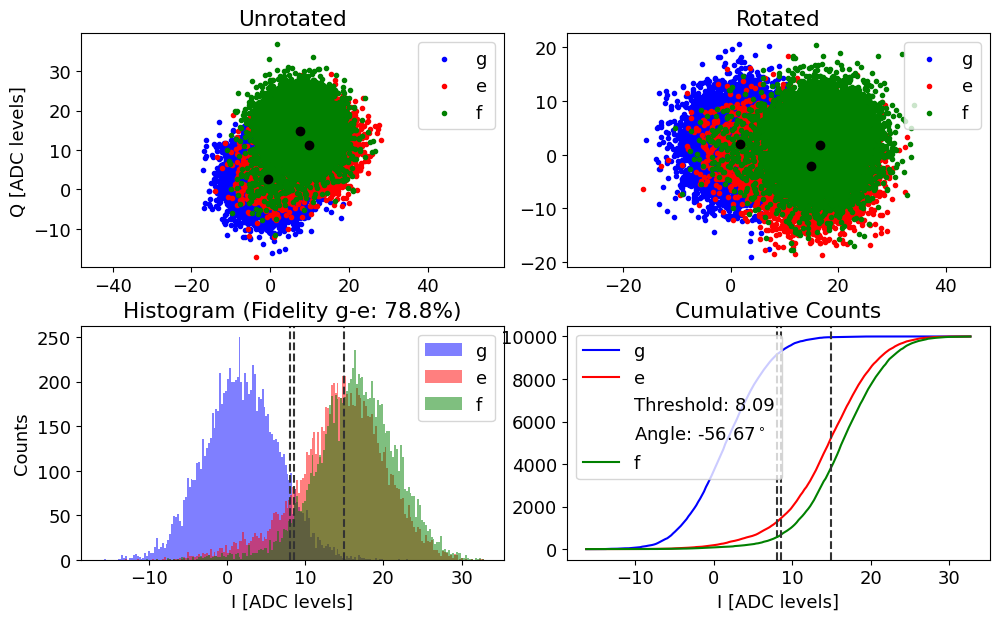

ge fidelity (%): 78.84394219710985
gf fidelity (%): 86.29725945189037
ef fidelity (%): 14.143535883970992
rotation angle (deg): -56.67461970747008
threshold ge: 8.089970120890097
threshold gf: 8.581647592309565
threshold ef: 14.973454720762621


In [4]:
i=0
shot = cfg.make_singleshot(soc, expt_path, cfg_path, i, go=True, check_f=True)


In [ ]:
rb = cfg.make_rb(soc, expt_path, cfg_path, i, go=True)


### Echo

In [ ]:
t2e = cfg.make_t2e(soc, expt_path, cfg_path, i, ramsey_freq=0.02, step=1.4, npts=400)
t2e.go(analyze=True, display=True, progress=True, save=True)

### Readout opt 

#### 3D Sweep

In [8]:
shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=20000, npts_f=7, npts_gain=7, npts_len=7, check_f=True)
shotopt.go(analyze=False, display=False, progress=False, save=True)

  0%|          | 0/7 [00:00<?, ?it/s]

<Pyro4.core.Proxy at 0x1d92516fdf0; not connected; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

	fid gf [%]: 2.1101055052752637
<Pyro4.core.Proxy at 0x1d92516fdf0; connected IPv4; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

#### 2D Sweep

In [112]:
shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=1, npts_gain=5, npts_len=5, start_gain=6000, span_gain=4500, start_len=12, span_len=25)
#shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=6, span_f=0.7, npts_gain=1, npts_len=5, start_len=12, span_len=25)

shotopt.go(analyze=False, display=False, progress=False, save=True)


<Pyro4.core.Proxy at 0x2bbd99b1930; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>
<Pyro4.core.Proxy at 0x2bbd99b1930; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>
<Pyro4.core.Proxy at 0x2bbd99b1930; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>
<Pyro4.core.Proxy at 0x2bbd99b1930; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>
<Pyro4.core.Proxy at 0x2bbd99b1930; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>
<Pyro4.core.Proxy at 0x2bbd99b1930; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>
<Pyro4.core.Proxy at 0x2bbd99b1930; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>
<Pyro4.core.Proxy at 0x2bbd99b1930; connected IPv4; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>
<Pyro4.core.Proxy at 0x2bbd99b19

(0, 2, 2)
[7099.4070587]
[ 6000.  7125.  8250.  9375. 10500.]
[12.   18.25 24.5  30.75 37.  ]
Max fidelity 61.533076653832694 %
Set params: 
 angle (deg) 74.80262006618209 
 threshold 3.4585523501634885 
 freq [Mhz] 7099.40705870269 
 Gain [DAC units] 8250.0 
 readout length [us] 24.5


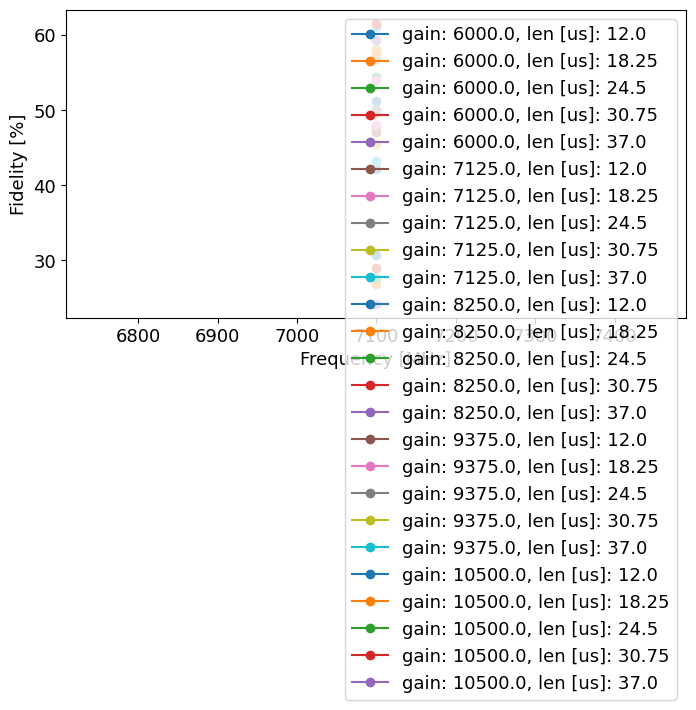

In [113]:
shotopt.analyze()
shotopt.display()

In [114]:
shotopt.data

{'fpts': array([7099.4070587]),
 'gainpts': array([ 6000.,  7125.,  8250.,  9375., 10500.]),
 'lenpts': array([12.  , 18.25, 24.5 , 30.75, 37.  ]),
 'fid': array([[[0.42134213, 0.49644964, 0.5440272 , 0.57632882, 0.57918688],
         [0.47102355, 0.54102705, 0.56815682, 0.58142907, 0.61119168],
         [0.51282564, 0.57692885, 0.61533077, 0.61453073, 0.5939891 ],
         [0.47762388, 0.48034803, 0.50015002, 0.45461365, 0.43185912],
         [0.30684603, 0.26835367, 0.27662448, 0.29018706, 0.24204841]]]),
 'threshold': array([[[2.84801363, 2.43718334, 2.81584514, 2.42881842, 2.45800516],
         [3.00825822, 3.34630417, 3.11158687, 2.98004187, 2.97052038],
         [3.60880381, 3.40426693, 3.45855235, 3.4097323 , 2.8576571 ],
         [4.18469332, 3.89147859, 3.28828945, 2.82001503, 2.50187237],
         [3.25260107, 2.1436428 , 1.926696  , 1.97061401, 1.22696062]]]),
 'angle': array([[[-71.66002242, -73.4695619 , -74.21112541, -74.2385473 ,
          -74.24848953],
         [-73.21

#### 1D Sweep

In [7]:

#shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=12, span_f=0.7, npts_gain=1, npts_len=1, start_len=12, span_len=25)

#Length
shotopt=cfg.make_singleshot_opt(soc, expt_path, cfg_path, i, im=im, reps=10000, npts_f=1, npts_gain=12, npts_len=1, check_f=True)

shotopt.go(analyze=False, display=False, progress=False, save=True)

<Pyro4.core.Proxy at 0x1d921f8c280; connected IPv4; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>
	fid gf [%]: 8.61
<Pyro4.core.Proxy at 0x1d921f8c280; connected IPv4; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>
	fid gf [%]: 25.192519251925194
<Pyro4.core.Proxy at 0x1d921f8c280; connected IPv4; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>
	fid gf [%]: 42.532126606330316
<Pyro4.core.Proxy at 0x1d921f8c280; connected IPv4; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>
	fid gf [%]: 56.98284914245713
<Pyro4.core.Proxy at 0x1d921f8c280; connected IPv4; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>
	fid gf [%]: 69.14728682170542
<Pyro4.core.Proxy at 0x1d921f8c280; connected IPv4; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@192.168.137.233:46689>
	fid gf [%]: 77.11771177117713
<Pyro4.core.Proxy at 0x1d921f8c280; connected IPv4; for PYRO:obj_1496e4438b1d4a0096f618a4a6ca2e73@1

In [110]:
shotopt.data

{'fpts': array([7099.4070587]),
 'gainpts': array([15000]),
 'lenpts': array([ 5.        ,  8.18181818, 11.36363636, 14.54545455, 17.72727273,
        20.90909091, 24.09090909, 27.27272727, 30.45454545, 33.63636364,
        36.81818182, 40.        ]),
 'fid': array([[[0.46502325, 0.53732687, 0.57534384, 0.55652261, 0.55752301,
          0.54434496, 0.5195078 , 0.51866346, 0.5331593 , 0.53477542,
          0.50180216, 0.48687112]]]),
 'threshold': array([[[8.23721673, 7.48797235, 6.96489041, 5.88476477, 5.63447013,
          4.91095098, 3.91988076, 3.51829249, 4.04801913, 3.51550308,
          2.92348234, 2.70108103]]]),
 'angle': array([[[-75.96470001, -75.45858594, -75.73951864, -75.52505713,
          -76.6596788 , -75.98372123, -74.82762345, -74.81871202,
          -75.08063558, -74.55597005, -73.94931221, -73.21257529]]]),
 'Ig': [[[array([-11.69355888,  -0.56994144, -10.52374756, ...,   7.72739102,
            -2.76382563,  -4.72999349]),
    array([  0.19968178,  -2.49124901,  -0

### Rabi EF

gauss


  0%|          | 0/2 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00003_amp_rabi_EF_ge_qubit0.h5
Pi gain from amps data [dac units]: 16726
	Pi/2 gain from amps data [dac units]: 8363
Pi gain from avgi data [dac units]: 16740
	Pi/2 gain from avgi data [dac units]: 8370
Pi gain from avgq data [dac units]: 16652
	Pi/2 gain from avgq data [dac units]: 8326


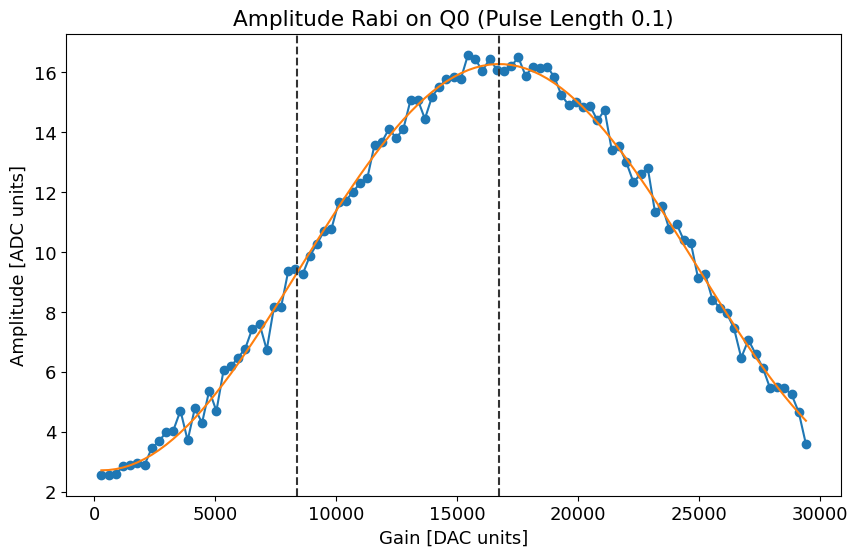

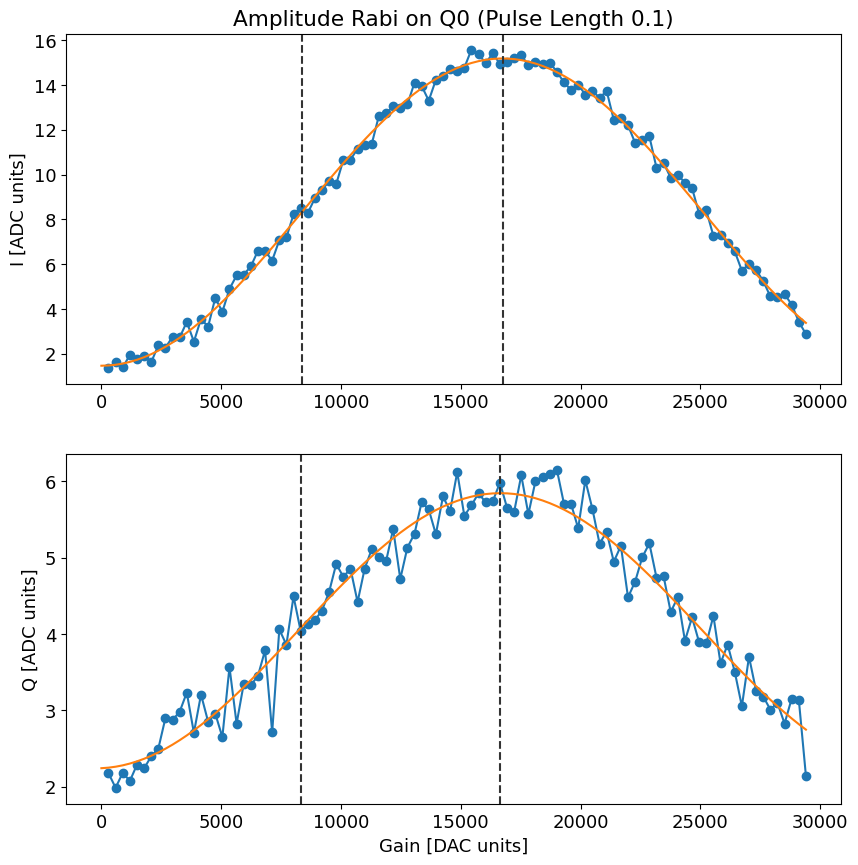

In [97]:
# Rabi EF 
#rabi=cfg.make_amprabi(soc, expt_path, cfg_path, i, go=True)
rabief=cfg.make_amprabiEF(soc, expt_path, cfg_path, i, go=True, pulse_ge=True)


In [98]:
auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ef','gain'), int(rabief.data['pi_length']), i)


*Set cfg qubit 0 ('pulses', 'pi_ef', 'gain') to 16740 from 10000*


#### Qubit Temperature

gauss


  0%|          | 0/2 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00004_amp_rabi_EF_ge_qubit0.h5
Pi gain from amps data [dac units]: 16646
	Pi/2 gain from amps data [dac units]: 8323
Pi gain from avgi data [dac units]: 16648
	Pi/2 gain from avgi data [dac units]: 8324
Pi gain from avgq data [dac units]: 16663
	Pi/2 gain from avgq data [dac units]: 8331


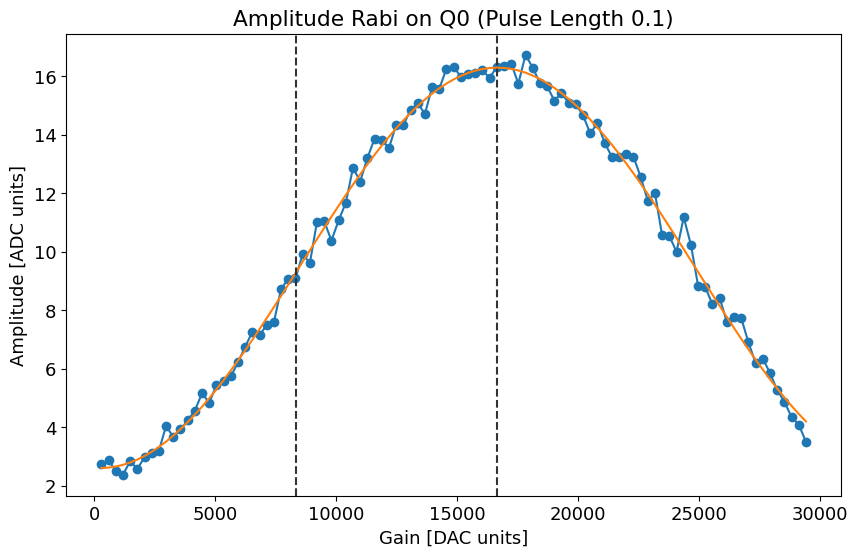

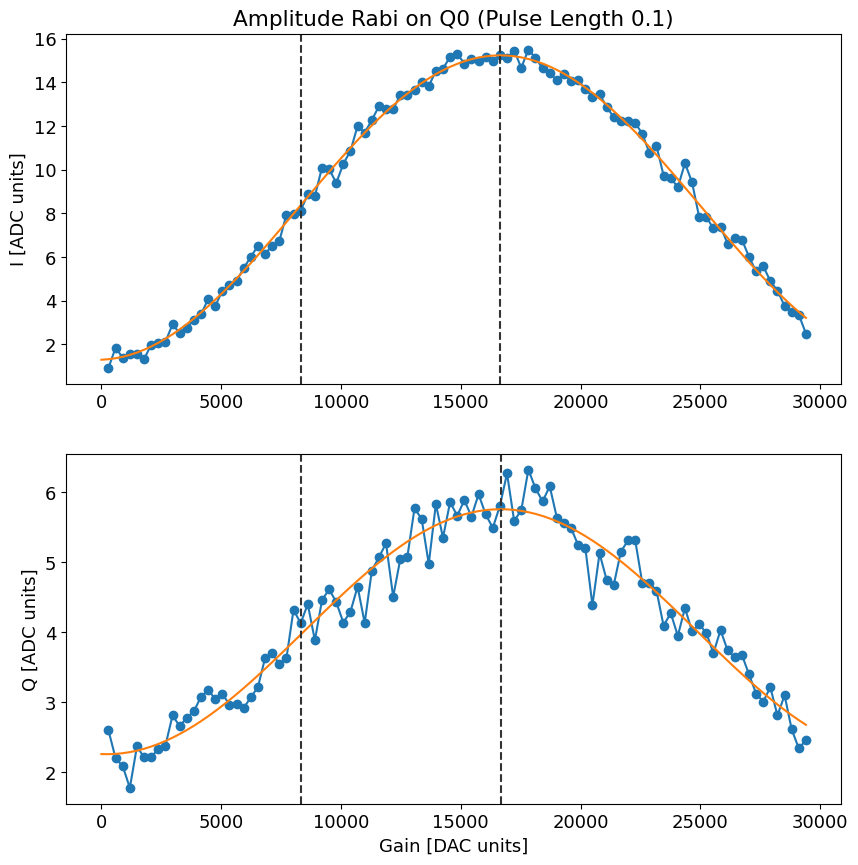

gauss


  0%|          | 0/100 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00003_amp_rabi_EF_qubit0.h5
Pi gain from amps data [dac units]: 16350
	Pi/2 gain from amps data [dac units]: 8175
Pi gain from avgi data [dac units]: 16368
	Pi/2 gain from avgi data [dac units]: 8184
Pi gain from avgq data [dac units]: 15673
	Pi/2 gain from avgq data [dac units]: 7836


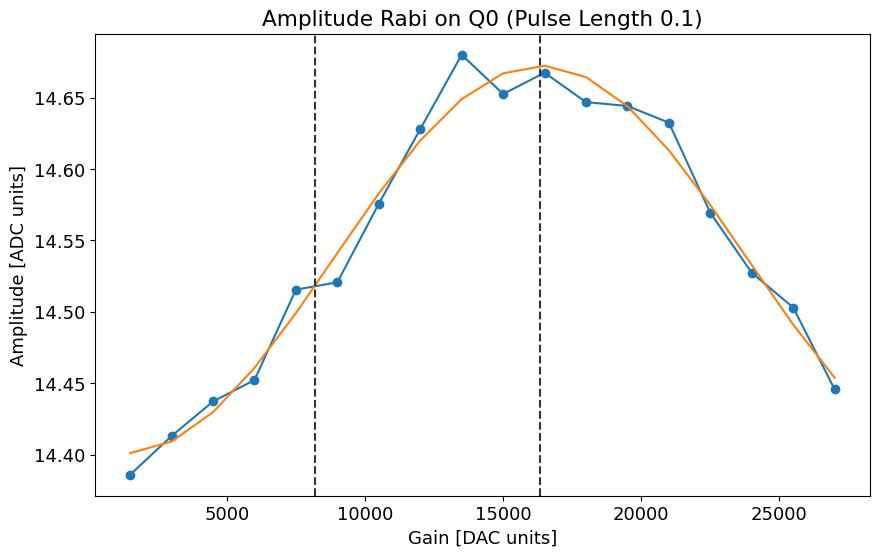

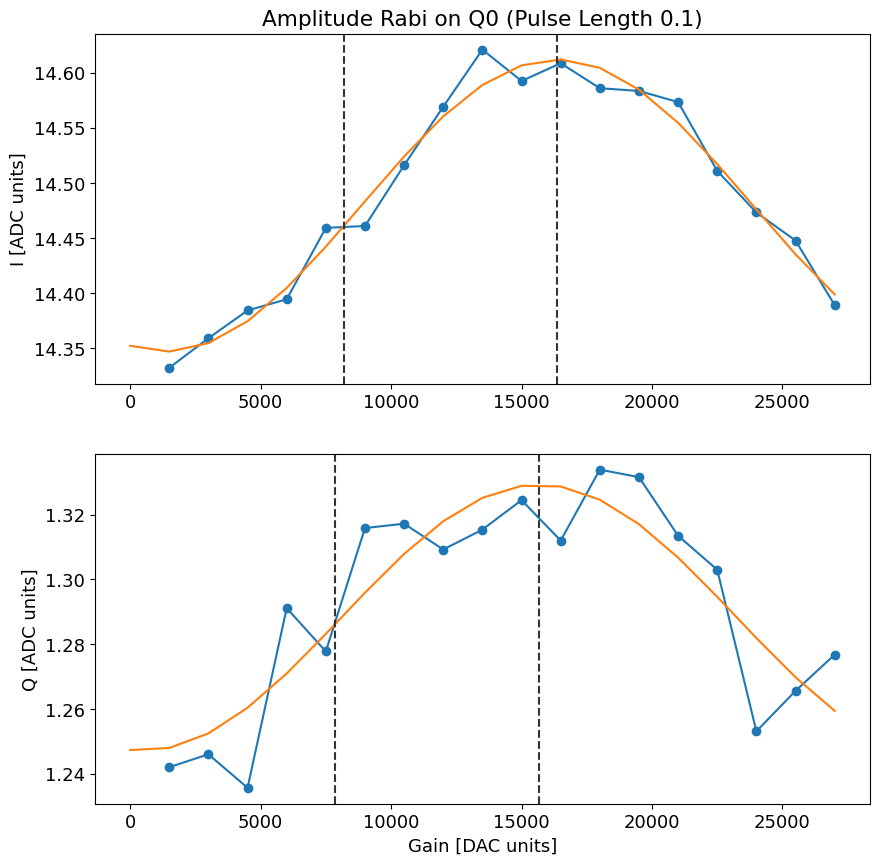

In [99]:
rabief=cfg.make_amprabiEF(soc, expt_path, cfg_path, i, go=True, pulse_ge=True)
rabief_nopulse=cfg.make_amprabiEF(soc, expt_path, cfg_path, i, go=True, pulse_ge=False, reps=1000, rounds=100, npts=20)

# To measure temperature, use fewer points to get more signal more quickly 
h = 6.62607015e-34
fge = 1e6*rabief.cfg.device.qubit.f_ge[i]
kB = 1.380649e-23

In [104]:

print('Qubit temp [mK]:', 1e3*h*fge/(kB*np.log(rabief.data['fit_amps'][0]/rabief_nopulse.data['fit_amps'][0])))
print('State preparation ratio:', rabief_nopulse.data['fit_amps'][0]/rabief.data['fit_amps'][0])

Qubit temp [mK]: 43.70694154013727
State preparation ratio: 0.019819883304763204


In [102]:
print(rabief.data['fit_amps'][0])
print(rabief_nopulse.data['fit_amps'][0])

6.843549636512281
0.13563835518602807


In [ ]:
print(rabief.data['fit_amps'][0])
print(rabief_nopulse.data['fit_amps'][0])

## Automated retune once things are working

<Pyro4.core.Proxy at 0x2bbd99b2b00; not connected; for PYRO:obj_f90cbadf8de648e59b61c0011eba9d33@192.168.137.233:35515>


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00007_single_shot_qubit3.h5
Unrotated:
Ig 0.41412041222202134 +/- 0.683872735420232 	 Qg 0.3697342252757187 +/- 0.6759852395612607 	 Amp g 0.5551568365418665
Ie 2.343789549810161 +/- 0.8823588845957545 	 Qe -0.3004881576568432 +/- 0.7032728739920737 	 Amp e 2.362973251370257
hi
Rotated:
Ig 0.2700554085134629 +/- 0.683872735420232 	 Qg 0.48732046103961457 +/- 0.6759852395612607 	 Amp g 0.5571455423991435
Ie 2.3197605500392315 +/- 0.8823588845957545 	 Qe 0.4707319966150776 +/- 0.7032728739920737 	 Amp e 2.3670398438039726


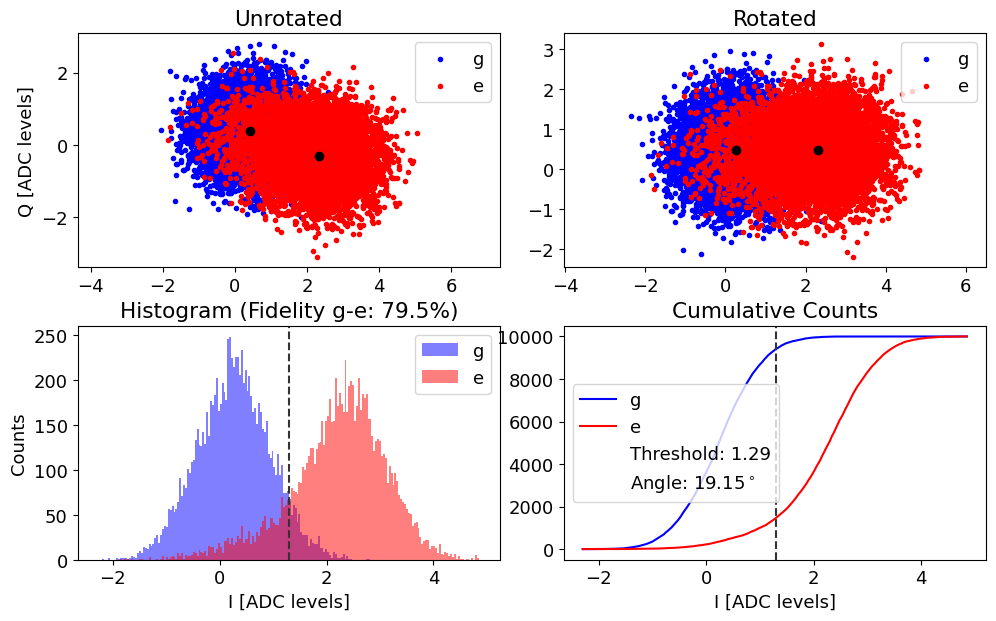

ge fidelity (%): 79.49397469873493
rotation angle (deg): 19.15339376222877
threshold ge: 1.294907979276347
*Set cfg resonator 3 phase to 19.15339376222877 from 0.440041191376142*
*Set cfg resonator 3 threshold to 1.294907979276347 from 6.870975408871033*
gauss


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00004_amp_rabi_qubit3.h5
Pi gain from amps data [dac units]: 15158
	Pi/2 gain from amps data [dac units]: 7579
Pi gain from avgi data [dac units]: 15154
	Pi/2 gain from avgi data [dac units]: 7577
Pi gain from avgq data [dac units]: 7326
	Pi/2 gain from avgq data [dac units]: 3663


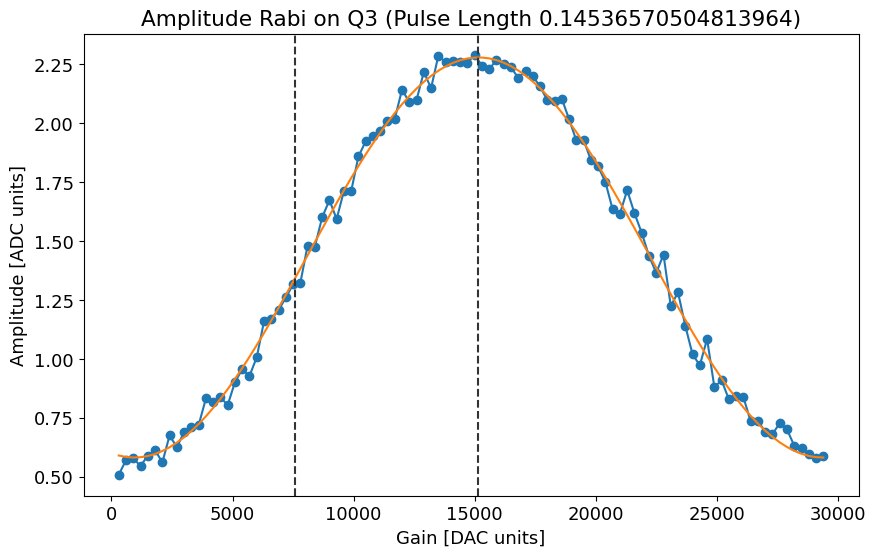

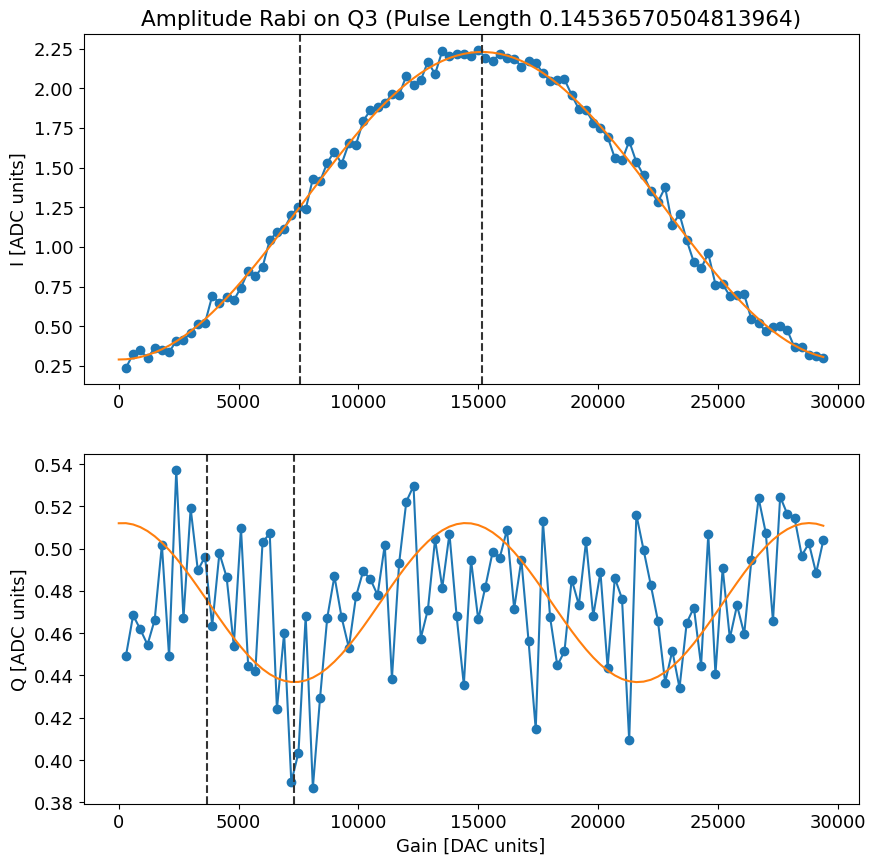

*Set cfg qubit 3 ('pulses', 'pi_ge', 'gain') to 15154 from 15223*


  0%|          | 0/2 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00001_ramsey_qubit3.h5
Current pi pulse frequency: 3548.8120344316053
Fit frequency from amps [MHz]: 0.09824486033824588 +/- 0.0001720171316289181
T2 Ramsey from fit amps [us]: 45.313494251101005
Current pi pulse frequency: 3548.8120344316053
Fit frequency from I [MHz]: 0.09823075487678053 +/- 0.00016707452217157783
T2 Ramsey from fit I [us]: 44.83763259499772
Fit frequency from Q [MHz]: 0.35255286012509995 +/- 0.0006177649559278242
T2 Ramsey from fit Q [us]: 44.7
Suggested new pi pulse frequency from fit 3548.8138:



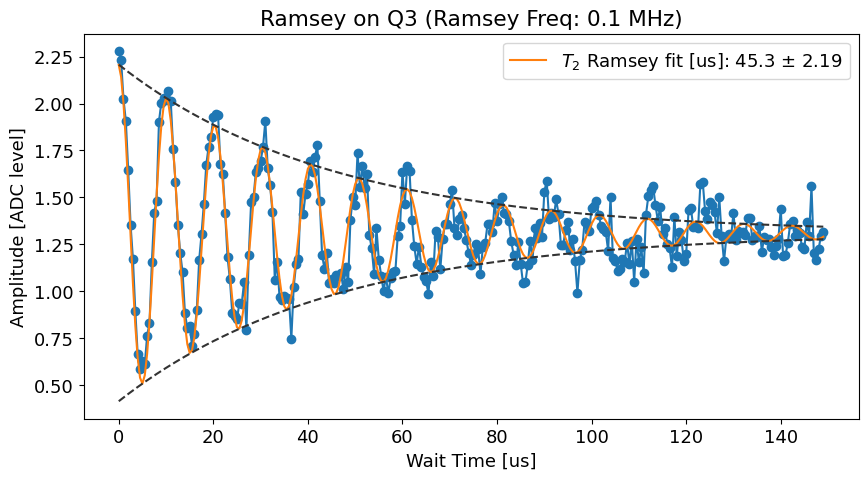

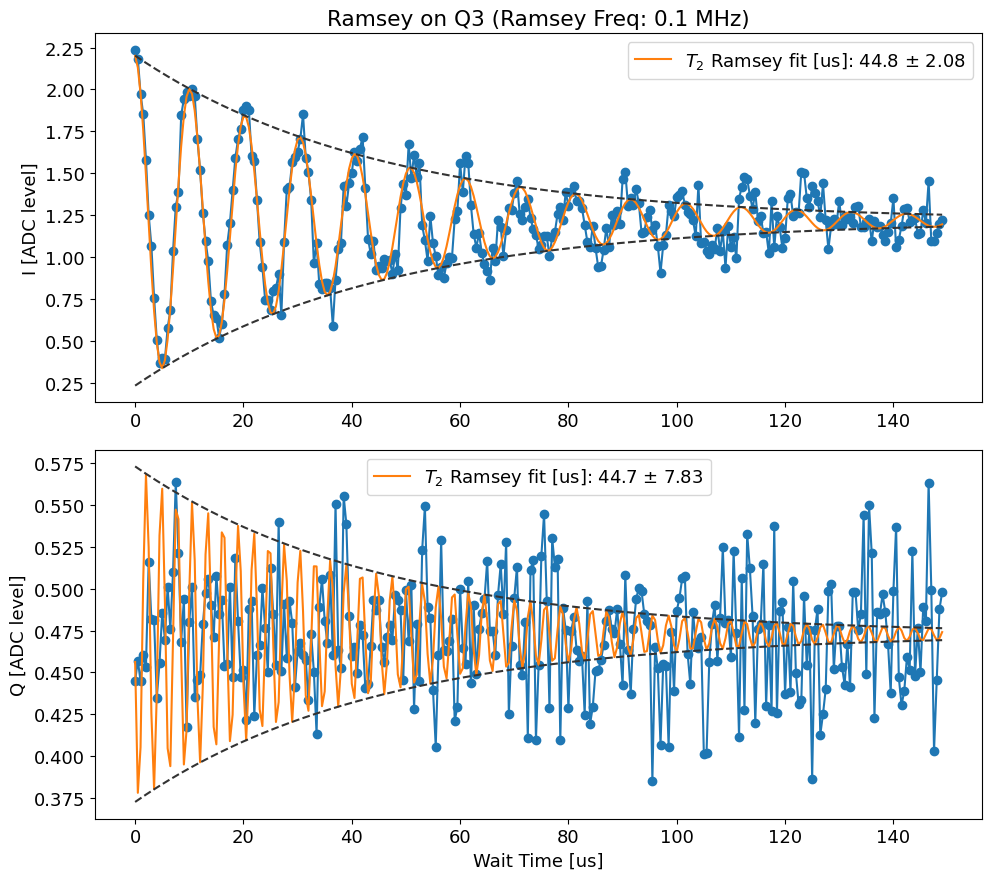

*Set cfg qubit 3 f_ge to 3548.8138036767286 from 3548.8120344316053*


  0%|          | 0/100000 [00:00<?, ?it/s]

c:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


t1_i error:fit ratio= 0.043826099315021794
t1_q error:fit ratio= inf
t1_i is better, saving T1_i to results cfg file
Saving C:\_Data\LLqub2\Tuning_2024_05_12\00002_t1_qubit3.h5
Fit T1 avgi [us]: 38.74833436176555
Fit T1 avgq [us]: 46.57574090117352


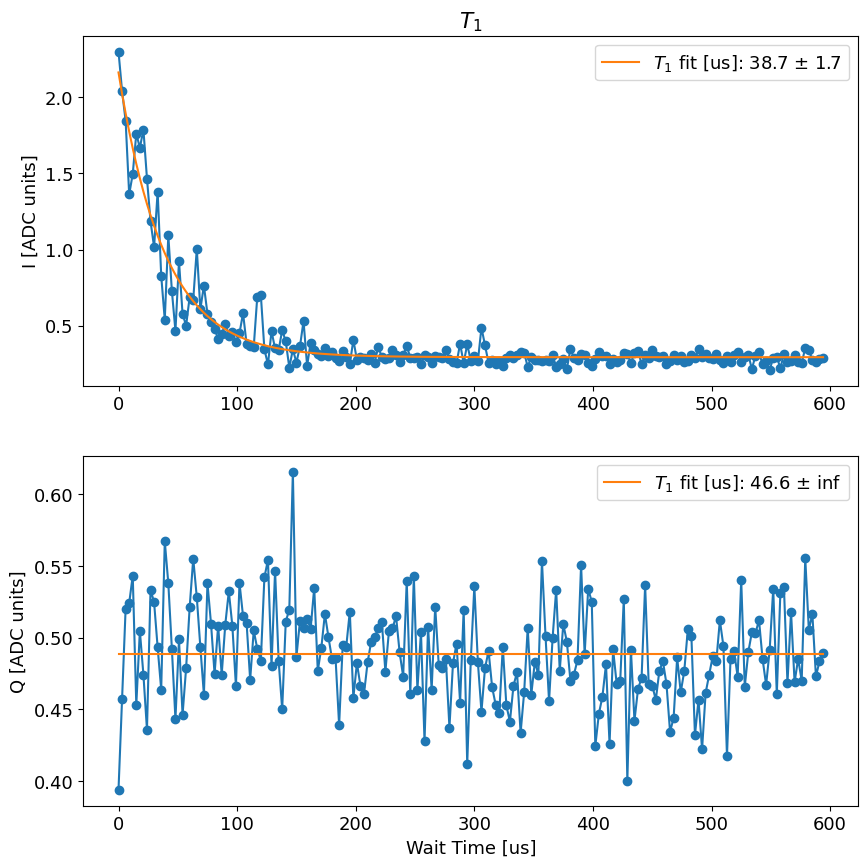

*Set cfg qubit 3 T1 to 38.74833436176555 from 202.20573347093816*


  0%|          | 0/2 [00:00<?, ?it/s]

Saving C:\_Data\LLqub2\Tuning_2024_05_12\00001_echo_qubit3.h5
Current qubit frequency: 3548.8138036767286
Fit frequency from I [MHz]: 0.02000688673549548 +/- 6.138194657907366e-05
T2 Echo from fit I [us]: 167.16
Fit frequency from Q [MHz]: 0.003947331771734928 +/- 0.00037972472192488826
T2 Echo from fit Q [us]: 167.16000000004362


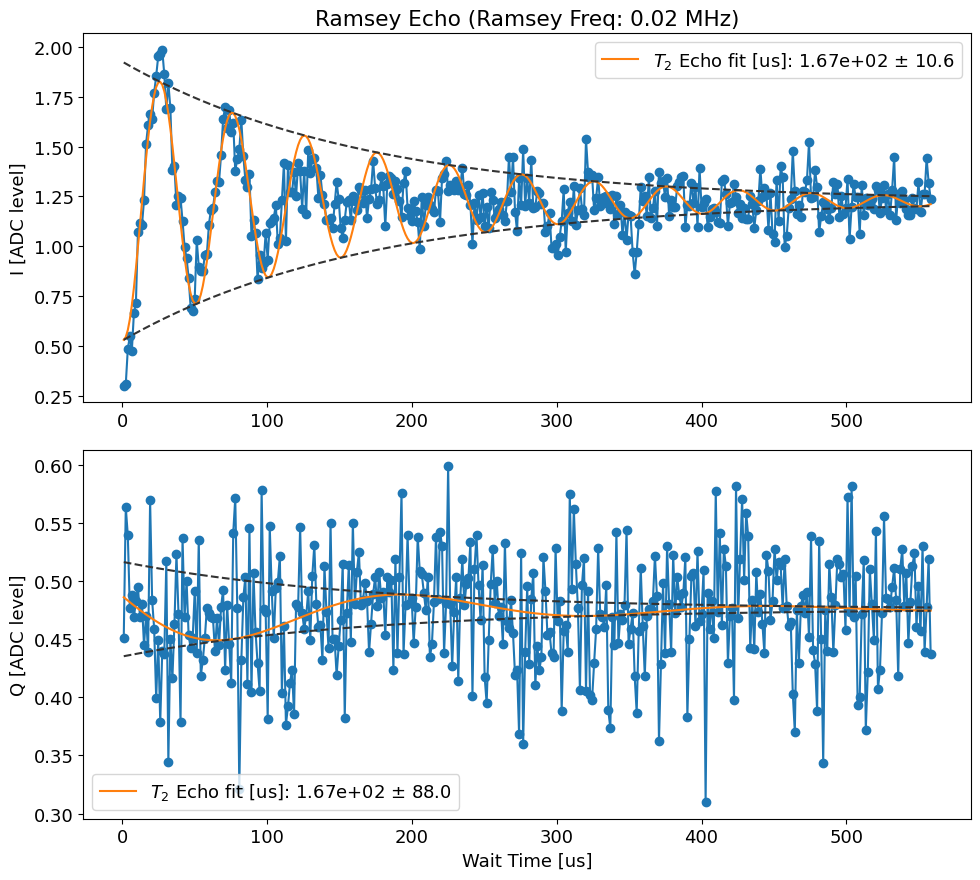

In [115]:
i=3
shot = cfg.make_singleshot(soc, expt_path, cfg_path, i, go=True)
config.update_readout(cfg_file, 'phase', float(shot.data['angle']), i);
config.update_readout(cfg_file, 'threshold', float(shot.data['thresholds'][0]), i);

amp_rabi = cfg.make_amprabi(soc, expt_path, cfg_path, i, go=True, gain=15000)
auto_cfg = config.update_qubit(cfg_file, ('pulses','pi_ge','gain'), int(amp_rabi.data['pi_length']), i)

t2r=cfg.make_t2r(soc, expt_path, cfg_path, i, go=True)
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(t2r.data['new_freq']), i)

t1 = cfg.make_t1(soc, expt_path, cfg_path, i, go=True) 
auto_cfg = config.update_qubit(cfg_file, 'T1', float(t1.data['new_t1']), i)

t2e = cfg.make_t2e(soc, expt_path, cfg_path, i,go=True, ramsey_freq=0.02, step=1.4, npts=400)